# Importing dependencies

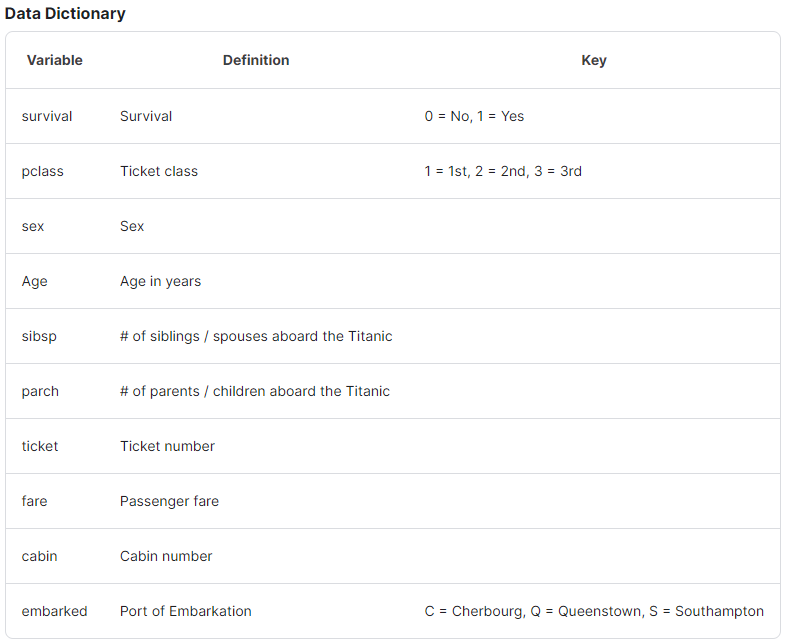

In [1]:
import pydot
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.exceptions import NotFittedError

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from IPython.display import display

In [2]:
path_train = '../datasets/titanic/train.csv'
path_test = '../datasets/titanic/test.csv'

# Useful functions

In [184]:
def get_missing_values_table(dataframe):
    # Missing values
    total = dataframe.isnull().sum().sort_values(ascending=False)
    # The percentage of missing values
    percent = (dataframe.isnull().sum() / dataframe.isnull().count()).sort_values(ascending=False)
    df_missing_data = pd.concat([total,percent],axis=1,keys=["Total","Percentage"])
    return df_missing_data


def display_confusion_matrix(target, prediction, score=None):
    cm = metrics.confusion_matrix(target, prediction)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        score_title = 'Accuracy Score: {0}'.format(round(score, 5))
        plt.title(score_title, size = 14)
    classification_report = pd.DataFrame.from_dict(metrics.classification_report(target, prediction, output_dict=True), orient='index')
    display(classification_report.round(2))
    
def visualize_tree(tree, feature_names):
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f, feature_names=feature_names)
    try:
        subprocess.check_call(["dot", "-Tpng", "dt.dot", "-o", "dt.png"])
    except:
        exit("Could not run dot, ie graphviz, to produce visualization")


# Data exploration

In [35]:
# Create dataframe for training dataset and print five first rows as preview
df_train = pd.read_csv(path_train)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
# Compute some basical statistics on the dataset
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [38]:
df_train["Age"].count()

714

In [39]:
df_train.shape

(891, 12)

In [40]:
df_train.isnull().sum()/df_train.isnull().count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [41]:
df_missing_values = get_missing_values_table(df_train)
df_missing_values

,Total,Percentage
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


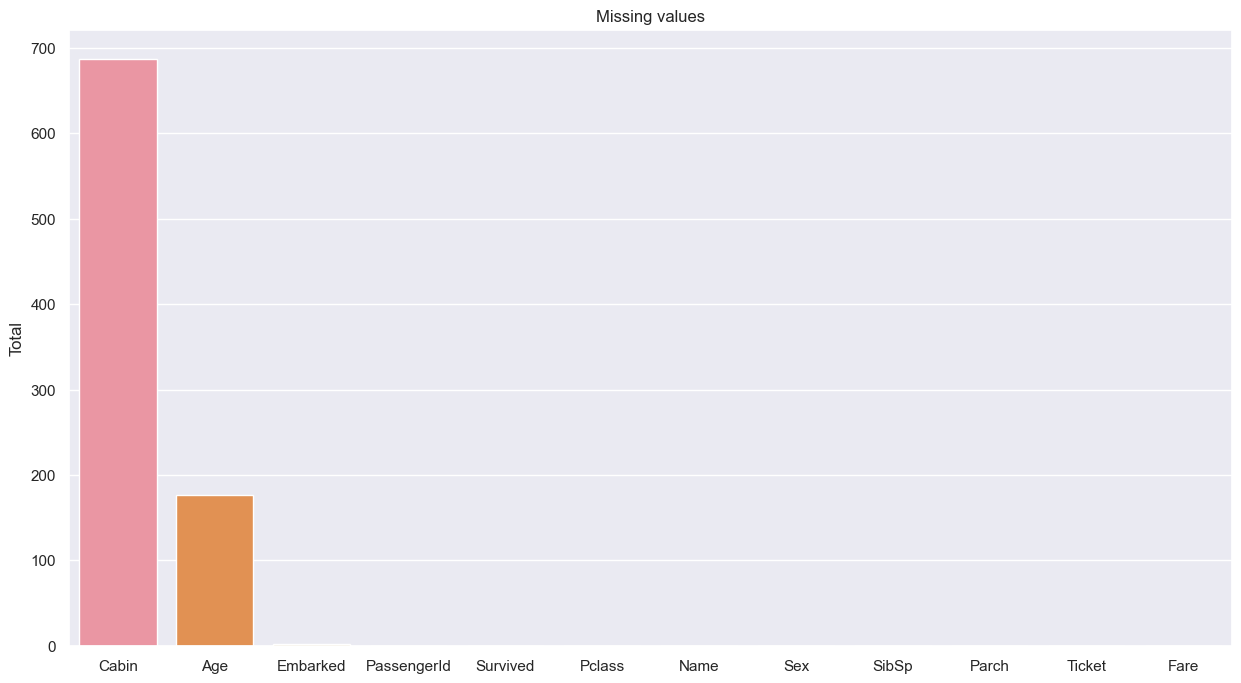

In [42]:
plt.figure(figsize=(15,8))
plt.title("Missing values");
sns.barplot(data=df_missing_values,x=df_missing_values.index.values,y="Total");

<Figure size 1600x600 with 0 Axes>

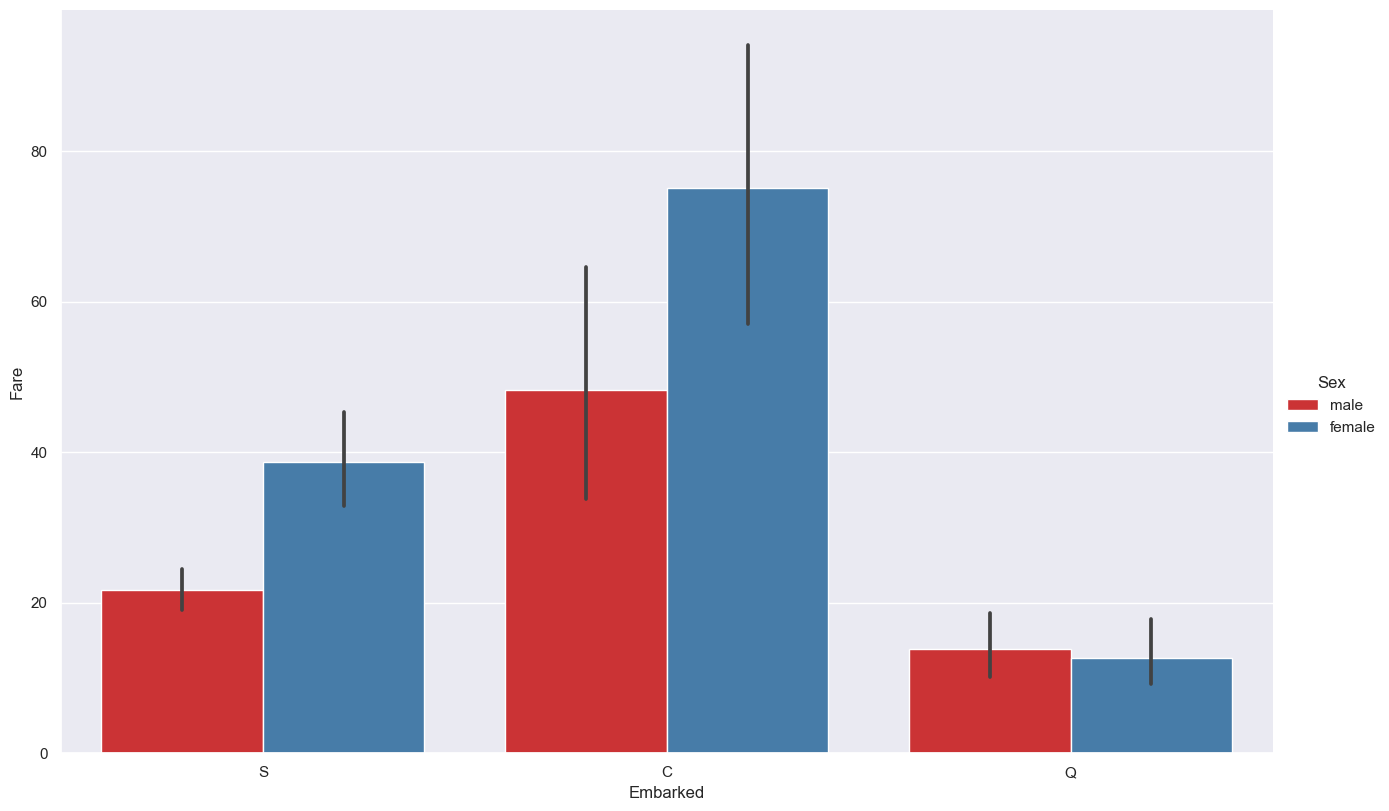

In [63]:
plt.figure(figsize=(16,6))
sns.catplot(x="Embarked", y="Fare", hue="Sex", data=df_train, palette=('Set1'), kind="bar", ax=axes,
           height=8.27, aspect=13/8.27)


Both passengers are female who paid 80 dollars as fare for their tickets. Moreover, they have the same ticket and cabin, so they probably had to board at the same place! According to the distribution above, the more probable embarked value for them is Cherbourg (C). We'll replace these two missing values later during features engineering part.

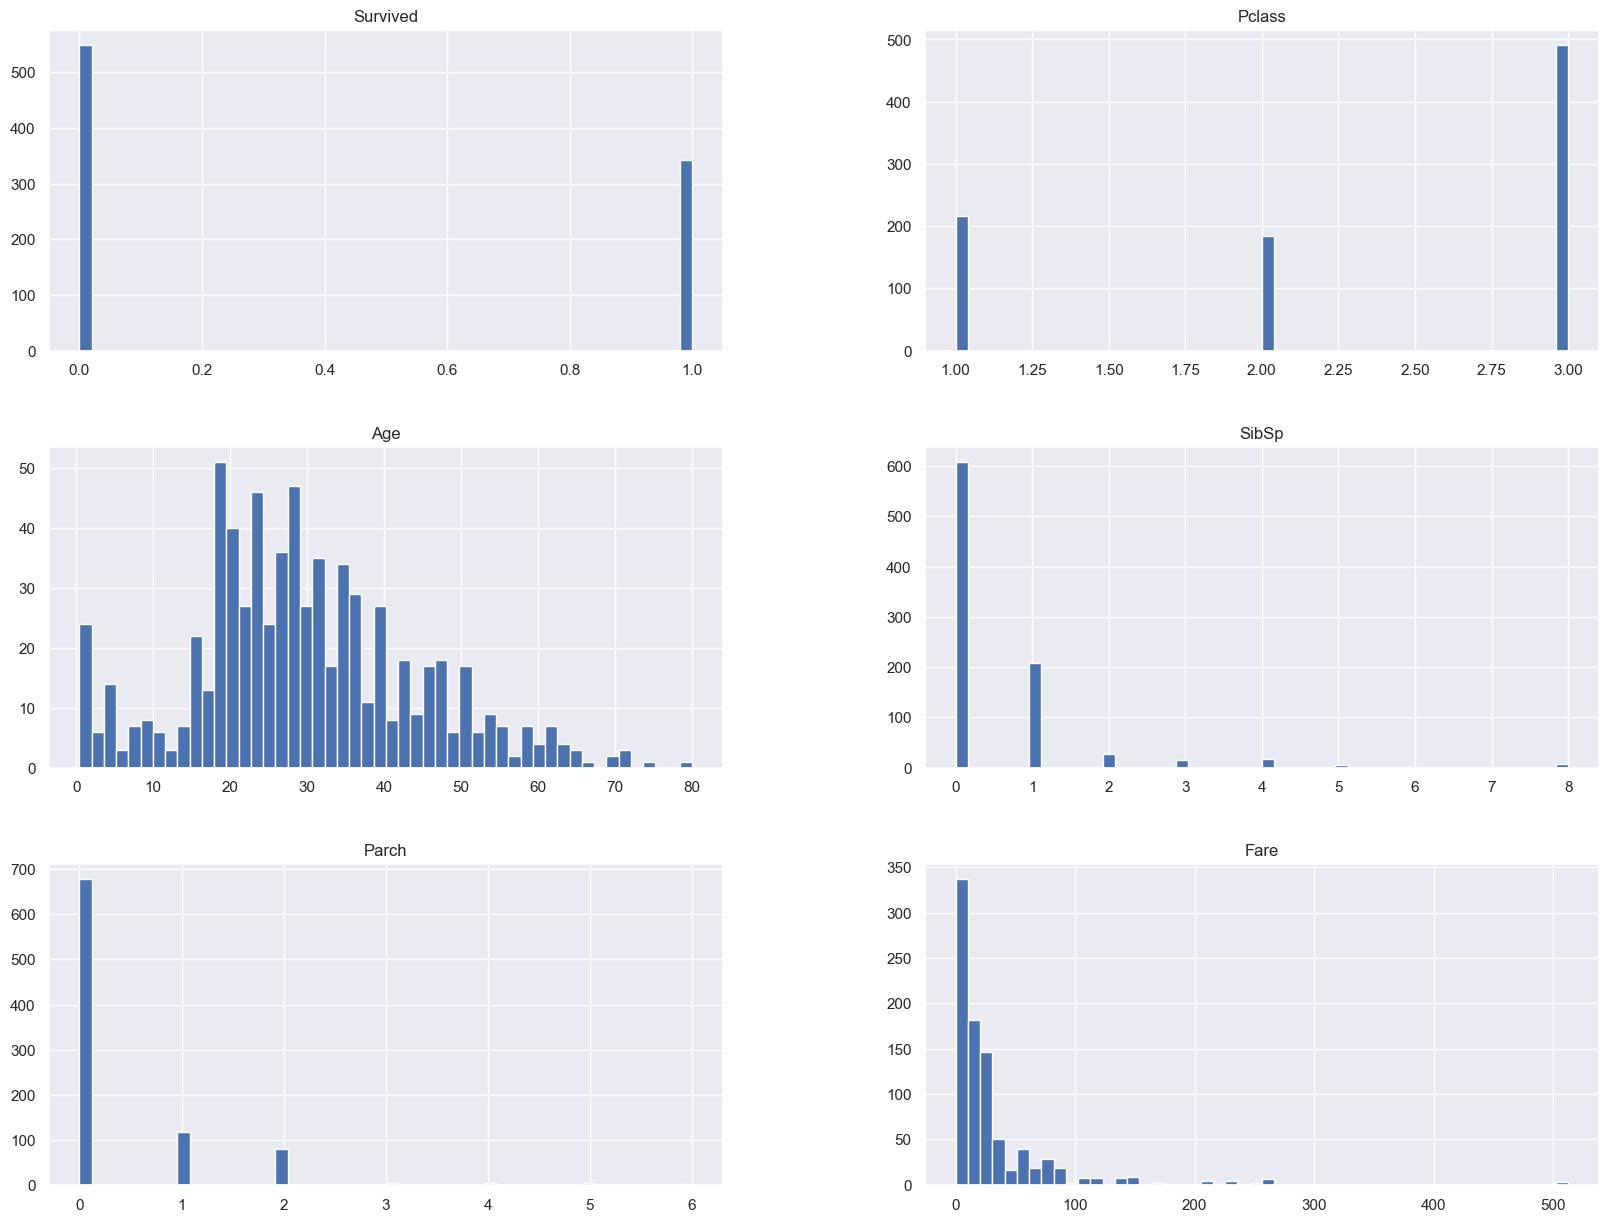

In [64]:
# Observing the distribution of variables
df_train.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot: xlabel='Survived', ylabel='count'>

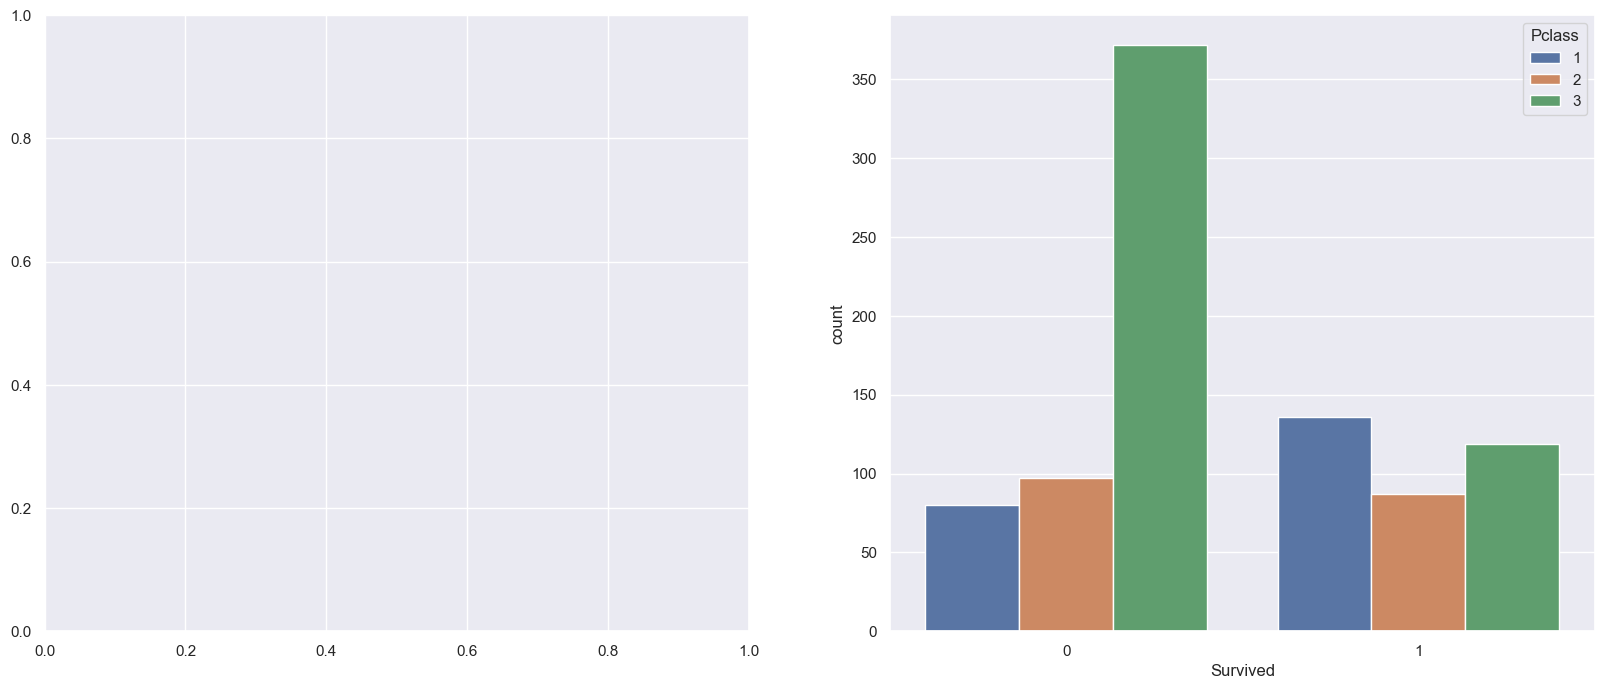

In [93]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
ax = plt.axes()
sns.countplot(data=df_train,x="Survived")


plt.subplot(1,2,2)
sns.countplot(data=df_train,x="Survived",hue="Pclass")

[Text(0, 0, 'Died'), Text(1, 0, 'Survived')]

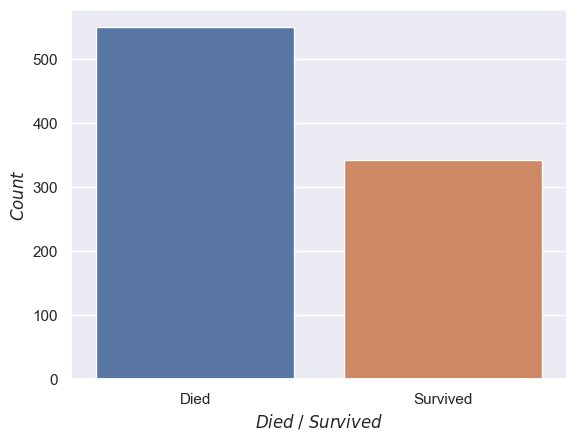

In [114]:
ax = plt.axes()
labels=["Died","Survived"]

sns.countplot(data=df_train,x="Survived",ax=ax)

ax.set_xlabel("$Died$ $/$ $Survived$")
ax.set_ylabel("$Count$")
ax.set_xticklabels(labels)

# Feature Engineering

In [178]:
def preprocess_data(df):
    
    processed_df = df
        
    ########## Deal with missing values ##########
    
    # As we saw before, the two missing values for embarked columns can be replaced by 'C' (Cherbourg)
    processed_df['Embarked'].fillna('C', inplace=True)
    
    # We replace missing ages by the mean age of passengers who belong to the same group of class/sex/family
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch','SibSp'])['Age'].transform(lambda x: x.fillna(x.mean()))
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch'])['Age'].transform(lambda x: x.fillna(x.mean()))
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    # We replace the only missing fare value for test dataset and the missing values of the cabin column
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U', inplace=True)
    
    ########## Feature engineering on columns ##########
    
    # Create a Title column from name column
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in df_train['Name']), index=df_train.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['Title'] = processed_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    
    # Filling Age missing values with mean age of passengers who have the same title
    processed_df['Age'] = processed_df.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.mean()))

    # Transform categorical variables to numeric variables
    processed_df['Sex'] = processed_df['Sex'].map({'male': 0, 'female': 1})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # Create a Family Size, Is Alone, Child and Mother columns
    processed_df['FamillySize'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['FamillySize'][processed_df['FamillySize'].between(1, 5, inclusive=False)] = 2
    processed_df['FamillySize'][processed_df['FamillySize']>5] = 3
    processed_df['IsAlone'] = np.where(processed_df['FamillySize']!=1, 0, 1)
    processed_df['IsChild'] = processed_df['Age'] < 18
    processed_df['IsChild'] = processed_df['IsChild'].astype(int)
    
    # Modification of cabin column to keep only the letter contained corresponding to the deck of the boat
    processed_df['Cabin'] = processed_df['Cabin'].str[:1]
    processed_df['Cabin'] = processed_df['Cabin'].map({cabin: p for p, cabin in enumerate(set(cab for cab in processed_df['Cabin']))})
    
    # Create a ticket survivor column which is set to 1 if an other passenger with the same ticket survived and 0 else
    # Note : this implementation is ugly and unefficient, if sombody found a way to do it easily with pandas (it must be a way), please comment the kernel with your solution !
    processed_df['TicketSurvivor'] = pd.Series(0, index=processed_df.index)
    tickets = processed_df['Ticket'].value_counts().to_dict()
    for t, occ in tickets.items():
        if occ != 1:
            table = df_train['Survived'][df_train['Ticket'] == t]
            if sum(table) != 0:
                processed_df['TicketSurvivor'][processed_df['Ticket'] == t] = 1
    
    # These two columns are not useful anymore
    processed_df = processed_df.drop(['Name', 'Ticket', 'PassengerId'], 1)    
    
    return processed_df

# Splitting train and test datasets

In [181]:
X = X = df_train.drop(['Survived'], axis=1)
y = df_train['Survived']

# Preprocess the data
X = preprocess_data(X)

# We scale our data, it is essential for a smooth working of the models. Scaling means that each columns as a 0 mean and a 1 variance
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
    
# Split dataset for model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamillySize,IsAlone,IsChild,TicketSurvivor
331,-1.566107,-0.737695,1.181540,-0.474545,-0.473674,-0.074583,0.342867,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
733,-0.369365,-0.737695,-0.483367,-0.474545,-0.473674,-0.386671,-0.349864,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
382,0.827377,-0.737695,0.182596,-0.474545,-0.473674,-0.488854,-0.349864,-0.571933,-0.707550,-0.670389,0.811922,-0.405840,-0.596795
704,0.827377,-0.737695,-0.261380,0.432793,-0.473674,-0.490280,-0.349864,-0.571933,-0.707550,0.668886,-1.231645,-0.405840,-0.596795
813,0.827377,1.355574,-1.741297,3.154809,2.008933,-0.018709,-0.349864,-0.571933,0.263832,2.008162,-1.231645,2.464027,-0.596795


# Metrics and models

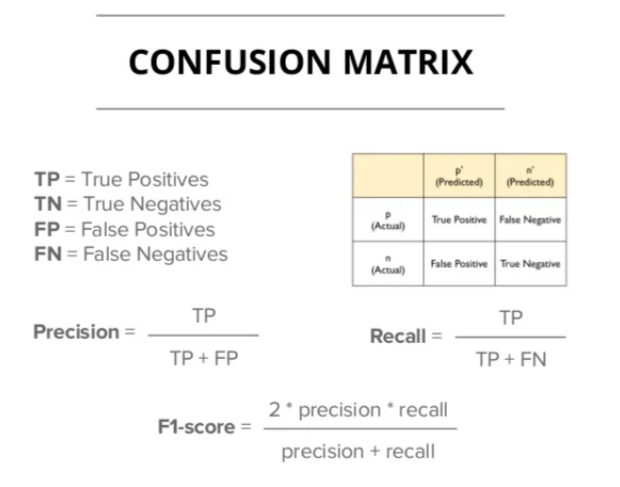

### 1.Logistic Regression

In [215]:
def display_conf_matrix(conf_matrix):
    ax=plt.axes();
    sns.heatmap(conf_matrix,annot=True,cmap="YlGnBu",ax=ax);

    ax.set_xticklabels(["Died","Survived"]);
    ax.set_yticklabels(["Died","Survived"]);
    ax.set_xlabel("Predicted Label");
    ax.set_ylabel("Actual Label");

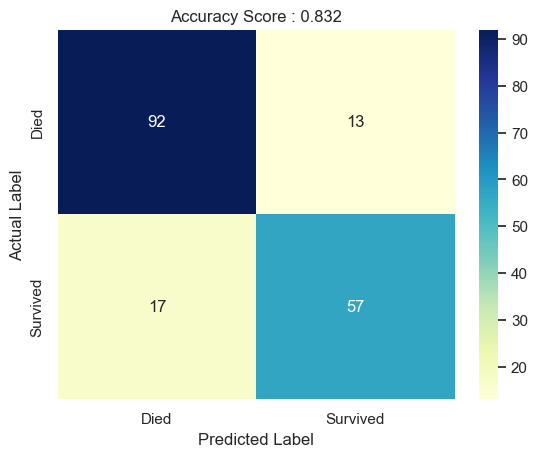

In [216]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Create and train model on train data sample
reg = LogisticRegression(solver='lbfgs', random_state=42)
reg.fit(X_train, y_train)

# Predict for test data sample
y_pred = reg.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
display_conf_matrix(conf_matrix=cm)
plt.title("Accuracy Score : %.3f" %(score));

**OPTIONAL : You can also use this method to display confusion matrix**



cm = confusion_matrix(y_pred,y_test)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Died","Survived"])

cm_display.plot()



#### 2.Decision Tree

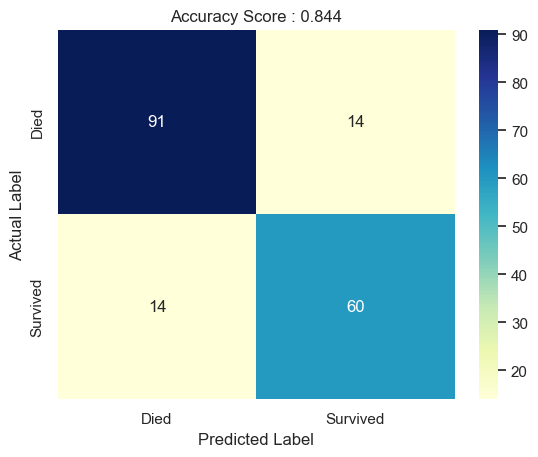

In [217]:
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
display_conf_matrix(conf_matrix=cm)
plt.title("Accuracy Score : %.3f" %(score));

In [221]:
from sklearn import tree
print(tree.export_text(dt))

|--- feature_8 <= -0.22
|   |--- feature_5 <= -0.12
|   |   |--- feature_12 <= 0.54
|   |   |   |--- feature_5 <= -0.37
|   |   |   |   |--- feature_5 <= -0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  -0.50
|   |   |   |   |   |--- feature_2 <= 0.07
|   |   |   |   |   |   |--- feature_5 <= -0.49
|   |   |   |   |   |   |   |--- feature_5 <= -0.49
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_5 >  -0.49
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_5 >  -0.49
|   |   |   |   |   |   |   |--- feature_2 <= -0.67
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_2 >  -0.67
|   |   |   |   |   |   |   |   |--- feature_2 <= -0.22
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_2 >  -0.22
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_2 >  0.07
|   |   |   |   |   |   |-

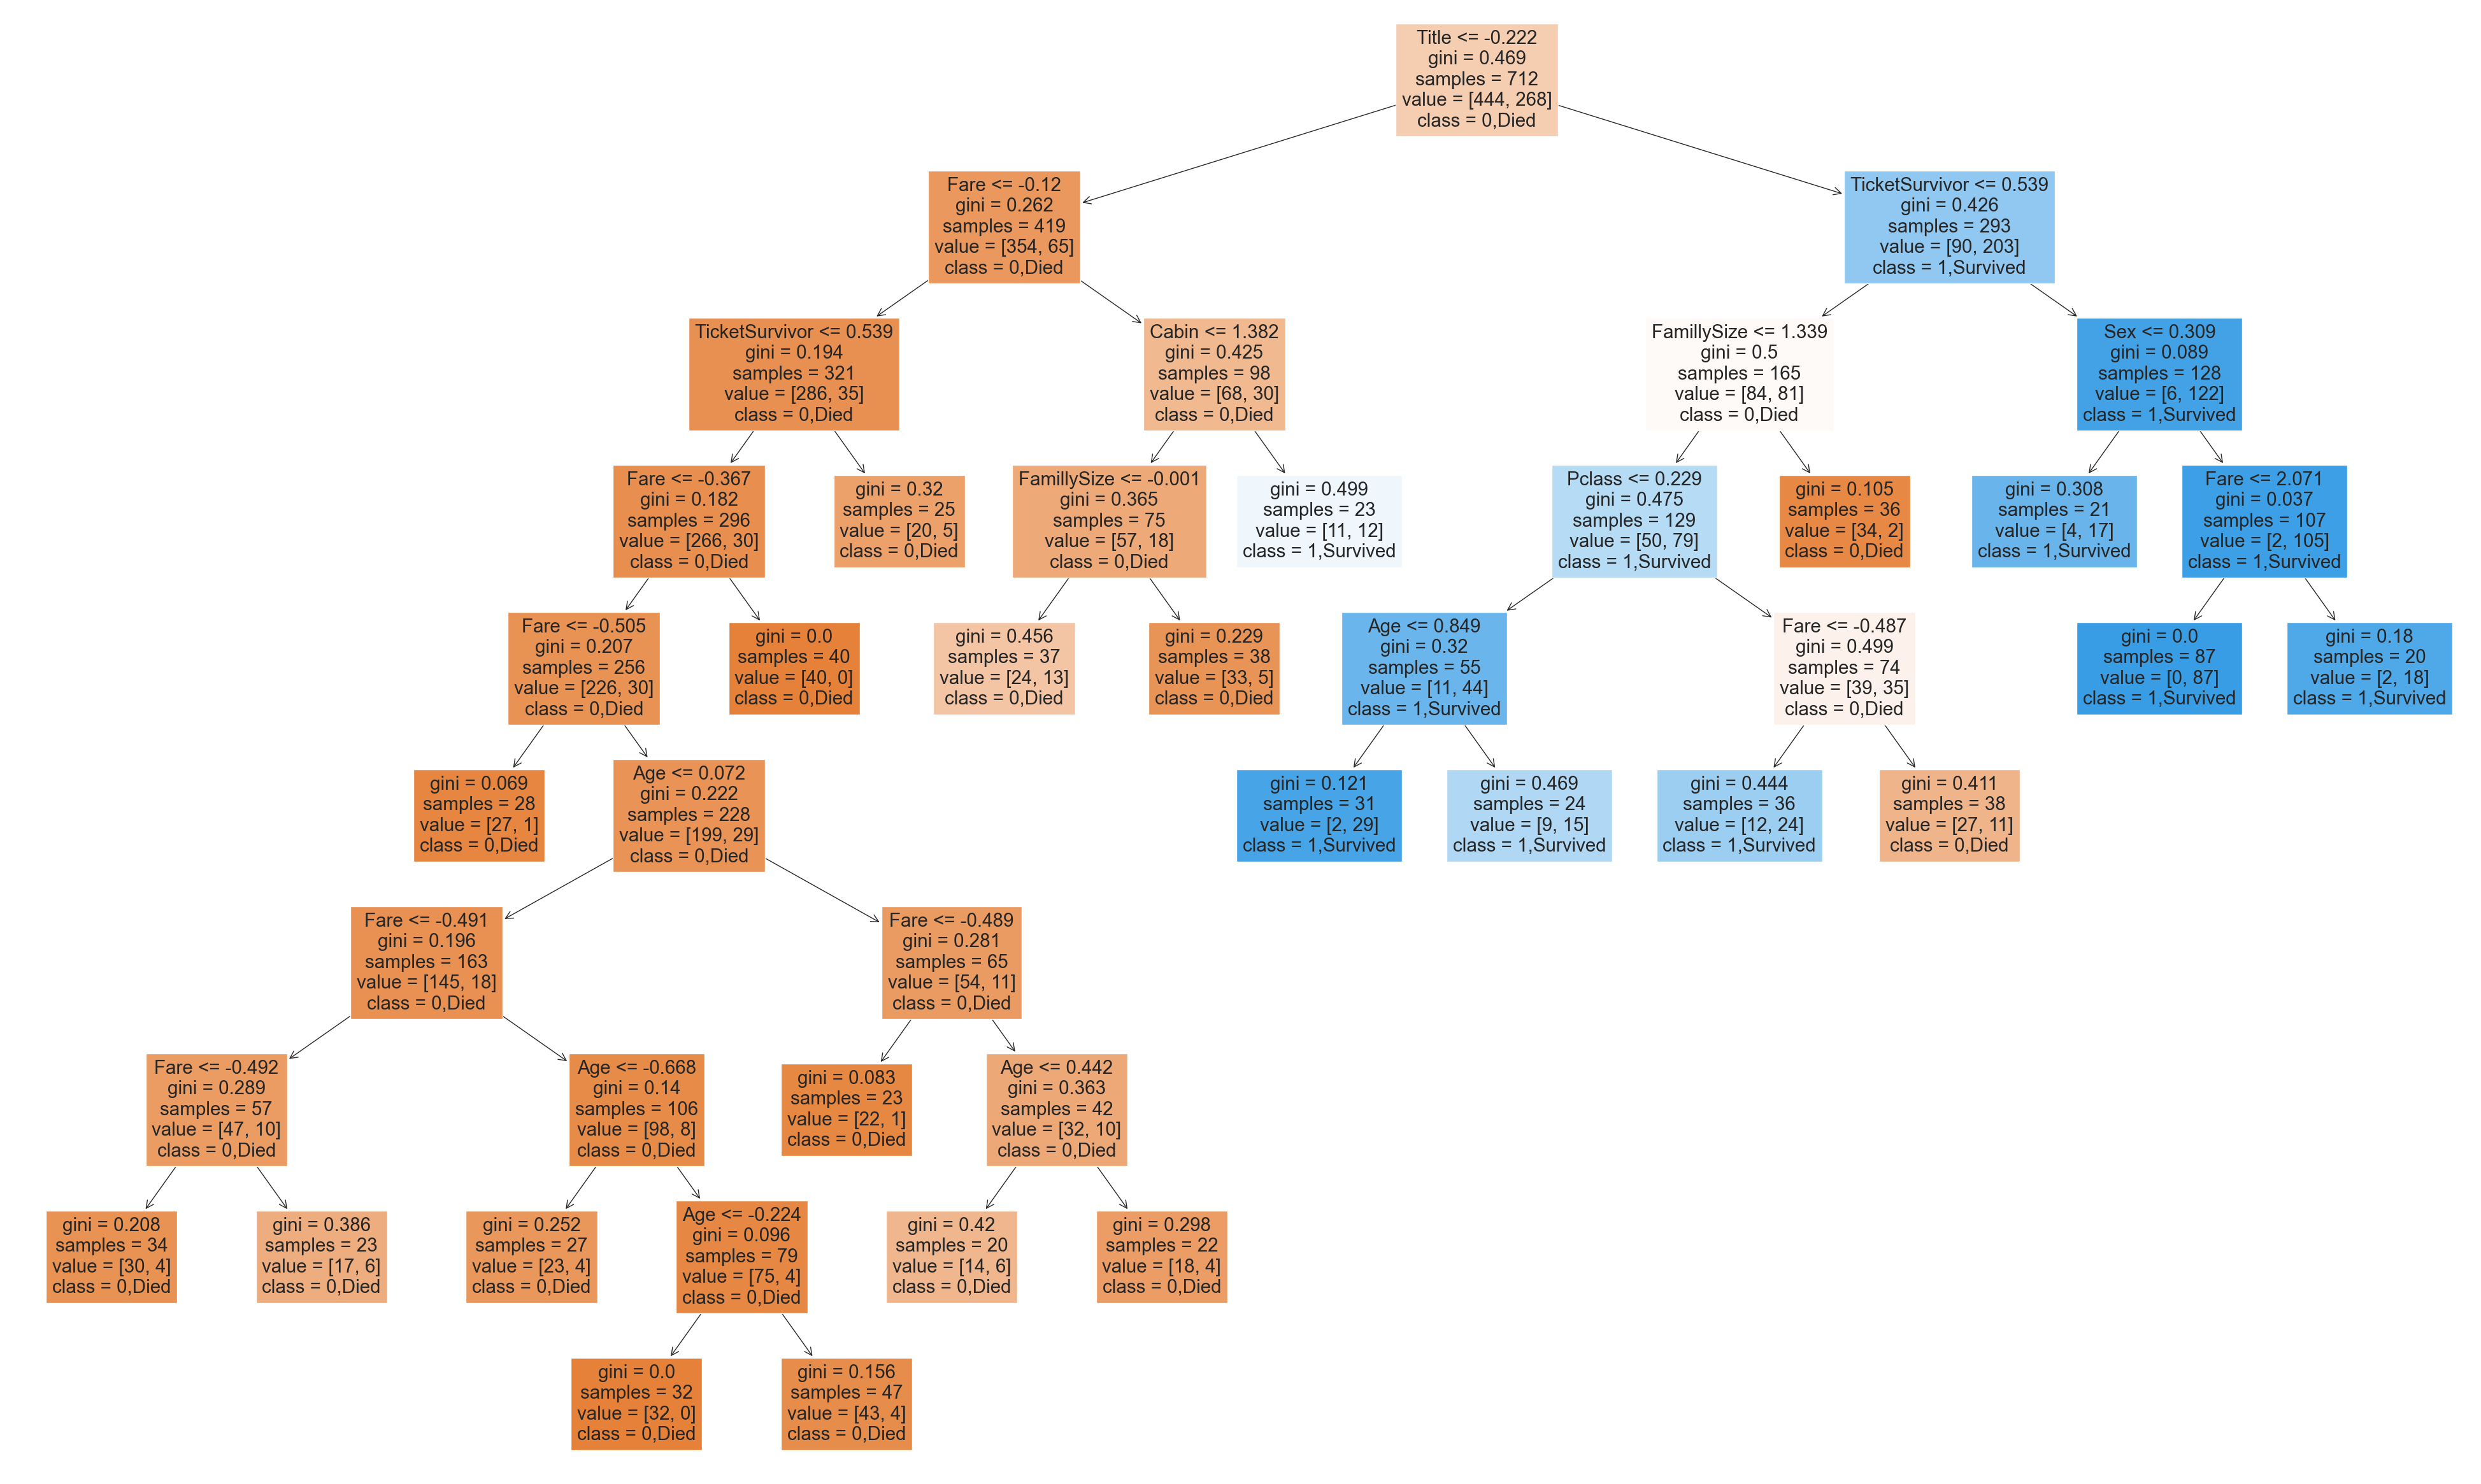

In [236]:
fig = plt.figure(figsize=(50,30))
_ = tree.plot_tree(decision_tree=dt,feature_names=X_train.columns.values,class_names=["0,Died","1,Survived"],filled=True)

### 3.SVM

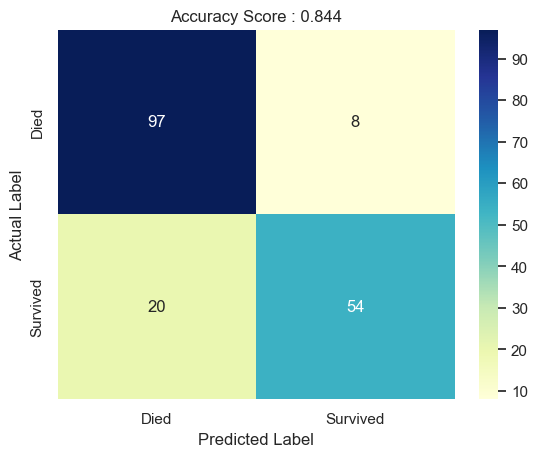

In [237]:
svm = SVC(gamma='auto', random_state=42)
svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
display_conf_matrix(conf_matrix=cm)
plt.title("Accuracy Score : %.3f" %(score));

### 4.Random Forests

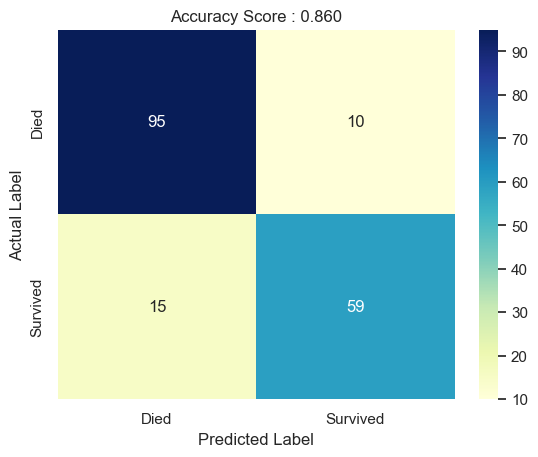

In [295]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
display_conf_matrix(conf_matrix=cm)
plt.title("Accuracy Score : %.3f" %(score));          

In [296]:
y_pred

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1], dtype=int64)

### 4.Artificial Neural Network

In [297]:
X_train.iloc[0,:].shape

(13,)

In [298]:
def build_ann(optimizer='adam'):
    
    # Initializing our ANN
    model = Sequential()
    
    # Adding the input layer and the first hidden layer of our ANN with dropout
    model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(13,)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(rate=0.5))
    
    # Adding the output layer
    model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [299]:
opt = optimizers.Adam(lr=0.001)
model = build_ann(opt)
# Training the ANN
history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, Y_test))

Epoch 1/30
45/45 [==============================] - 1s 5ms/step - loss: 0.6686 - accuracy: 0.5941 - val_loss: 0.5711 - val_accuracy: 0.7765
Epoch 2/30
45/45 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7163 - val_loss: 0.4744 - val_accuracy: 0.8045
Epoch 3/30
45/45 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.7949 - val_loss: 0.4202 - val_accuracy: 0.7989
Epoch 4/30
45/45 [==============================] - 0s 2ms/step - loss: 0.4443 - accuracy: 0.8287 - val_loss: 0.4030 - val_accuracy: 0.7989
Epoch 5/30
45/45 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.8455 - val_loss: 0.3891 - val_accuracy: 0.8101
Epoch 6/30
45/45 [==============================] - 0s 2ms/step - loss: 0.4115 - accuracy: 0.8301 - val_loss: 0.3734 - val_accuracy: 0.8156
Epoch 7/30
45/45 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.8385 - val_loss: 0.3692 - val_accuracy: 0.8212
Epoch 8/30
45/45 [==

6/6 [==============================] - 0s 798us/step


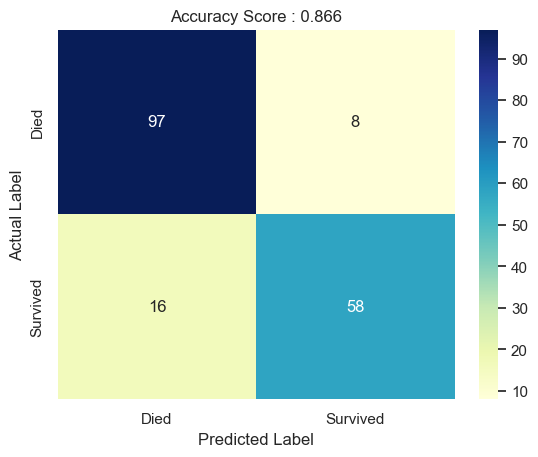

In [314]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
display_conf_matrix(conf_matrix=cm)
plt.title("Accuracy Score : %.3f" %(score));  

### Finding the best model using k-folds cross validation 

**Cross-Validation is a statistical method of evaluating and comparing learning algorithms by dividing data into two segments: one used to learn or train a model and the other used to validate the model.**



**Cross Validation is usually a very good way to measure an accurate performance. While it does not prevent your model to overfit, it still measures a true performance estimate. If your model overfits you it will result in worse performance measures. I applied a standard technique to overcome overfitting.**

In [315]:
y_pred

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
    

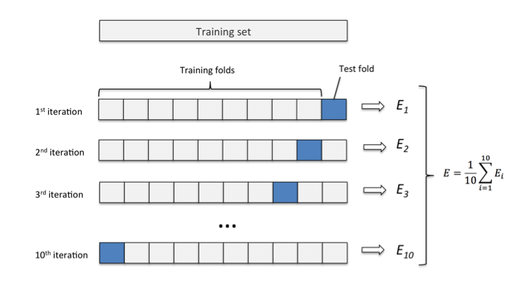

In [304]:
n_folds = 10      # Number of folds
cv_score_lg = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=n_folds, n_jobs=-1)
cv_score_dt = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=n_folds, n_jobs=-1)
cv_score_svm = cross_val_score(estimator=svm, X=X_train, y=y_train, cv=n_folds, n_jobs=-1)
cv_score_rf = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=n_folds, n_jobs=-1)
cv_score_ann = cross_val_score(estimator=KerasClassifier(build_fn=build_ann, batch_size=16, epochs=20, verbose=0),
                                 X=X_train, y=y_train, cv=n_folds, n_jobs=-1)

In [305]:
cv_result = {'lg': cv_score_lg, 'dt': cv_score_dt, 'svm': cv_score_svm, 'rf': cv_score_rf, 'ann': cv_score_ann}
cv_result

{'lg': array([0.83333333, 0.81944444, 0.77464789, 0.92957746, 0.87323944,
        0.74647887, 0.81690141, 0.8028169 , 0.83098592, 0.92957746]),
 'dt': array([0.83333333, 0.76388889, 0.77464789, 0.88732394, 0.87323944,
        0.78873239, 0.83098592, 0.8028169 , 0.77464789, 0.91549296]),
 'svm': array([0.86111111, 0.83333333, 0.76056338, 0.94366197, 0.88732394,
        0.76056338, 0.8028169 , 0.8028169 , 0.8028169 , 0.91549296]),
 'rf': array([0.81944444, 0.73611111, 0.76056338, 0.87323944, 0.83098592,
        0.78873239, 0.78873239, 0.85915493, 0.84507042, 0.91549296]),
 'ann': array([0.80555558, 0.80555558, 0.78873241, 0.90140843, 0.85915494,
        0.78873241, 0.80281693, 0.80281693, 0.85915494, 0.91549295])}

In [306]:
cv_data = {model: [score.mean(), score.std()] for model, score in cv_result.items()}
cv_df = pd.DataFrame(cv_data, index=['Mean_accuracy', 'Variance'])
cv_df

,lg,dt,svm,rf,ann
Mean_accuracy,0.835700,0.824511,0.83705,0.821753,0.832942
Variance,0.056965,0.050116,0.05988,0.051702,0.044834


In [307]:
cv_df = cv_df.T
cv_df

,Mean_accuracy,Variance
lg,0.835700,0.056965
dt,0.824511,0.050116
svm,0.837050,0.059880
rf,0.821753,0.051702
ann,0.832942,0.044834


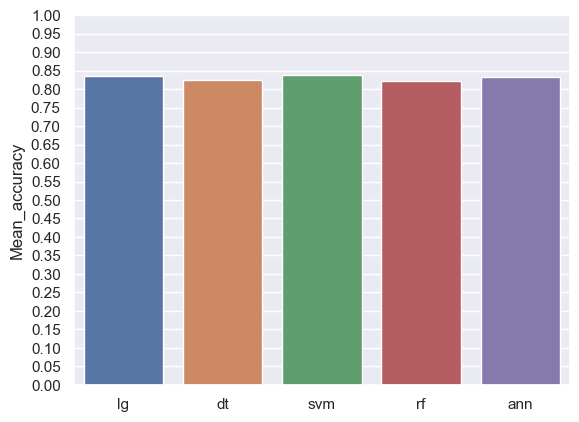

In [308]:
sns.barplot(data=cv_df,x=cv_df.index.values,y="Mean_accuracy");
plt.yticks(np.linspace(0.0,1.0,21).tolist());

## Display the accuracy for each fold

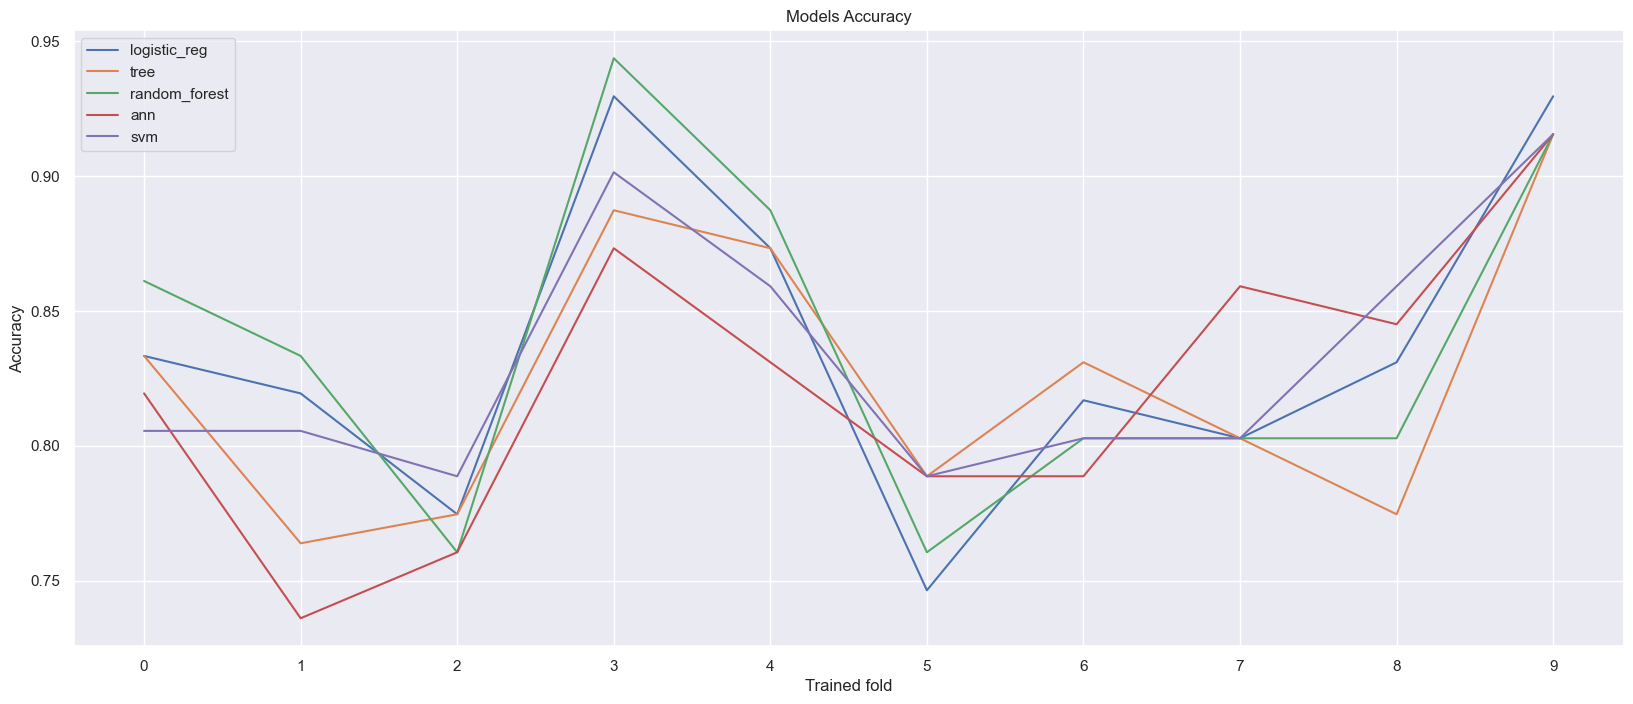

In [309]:
plt.figure(figsize=(20,8))
plt.plot(cv_result['lg'])
plt.plot(cv_result['dt'])
plt.plot(cv_result['svm'])
plt.plot(cv_result['rf'])
plt.plot(cv_result['ann'])
plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')
plt.xticks([k for k in range(n_folds)])
plt.legend(['logistic_reg', 'tree', 'random_forest', 'ann', 'svm'], loc='upper left')
plt.show()

# Create own classifier

In [310]:
class EnsemblingClassifier:
    
    def __init__(self, verbose=True):
        self.ann = build_ann(optimizer=optimizers.Adam(lr=0.001))
        self.rf = RandomForestClassifier(n_estimators=300, max_depth=11, random_state=42)
        self.svm = SVC(random_state=42)
        self.trained = False
        self.verbose = verbose
        
    def fit(self, X, y):
        if self.verbose:
            print('-------- Fitting models --------')
        self.ann.fit(X, y, epochs=30, batch_size=16, verbose=0)
        self.rf.fit(X, y)
        self.svm.fit(X, y)
        self.trained = True
    
    def predict(self, X):
        if self.trained == False:
            raise NotFittedError('Please train the classifier before making a prediction')
        if self.verbose:
            print('-------- Making and combining predictions --------')
        predictions = list()
        pred_ann = self.ann.predict(X)
        pred_ann = (pred_ann > 0.5)*1
        pred_rf = self.rf.predict(X)
        pred_svm = self.svm.predict(X)
        for n in range(len(pred_ann)):
            combined = pred_ann[n] + pred_rf[n] + pred_svm[n]
            p = 0 if combined == 1 or combined == 0 else 1
            predictions.append(p)
        return predictions

-------- Fitting models --------
-------- Making and combining predictions --------
6/6 [==============================] - 0s 4ms/step


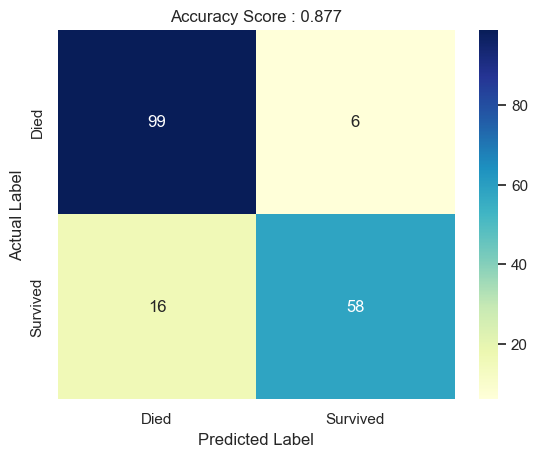

In [311]:
hybrid = EnsemblingClassifier()
hybrid.fit(X_train, Y_train)
y_pred_hybrid = hybrid.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(y_test, y_pred_hybrid)
cm = confusion_matrix(y_test,y_pred_hybrid)
display_conf_matrix(conf_matrix=cm)
plt.title("Accuracy Score : %.3f" %(score));  